# CI data analysis: availability sequences based on a common carbon budget

In [68]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
import math
import random 
from scipy import optimize
from scipy.optimize import milp

# from gekko import GEKKO
from scipy.optimize import linprog
import cvxpy as cp
import copy

import numpy as np
import time

import os

COUNTRIES = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
LIST_COLORS = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']
MAIN_FOLDER = 'availability_matrices/av-mat-5_av-mat-analysis'

In [69]:
class Window:
    def __init__(self, start_time=datetime(2022, 1, 1, 0, 0), random_start=False, n_rounds=100, countries=COUNTRIES, out_folder=MAIN_FOLDER):
        self.n_rounds=n_rounds # number of FL training rounds
        self.countries=countries

        self.n_clients=len(countries)
        self._dfs = load_data()
        self.tot_list_hours = self._dfs['Ireland']['datetime'].to_list() # list of hour timestamps

        # add here change with random choice TODO
        if random_start:
            self.start_time=random.choice(self.tot_list_hours[:-n_rounds+1])
        else:
            self.start_time=start_time # if -1 -> random choice, otherwise datetime value
        self.end_time = self.start_time + timedelta(hours=self.n_rounds-1)

        self.out_folder=out_folder+ "/" + self.start_time.strftime("%Y-%m-%d_%H")
        self.window_list_hours = get_datetime_values(self._dfs, countries[0], self.start_time, self.end_time)

        self._create_folders()
        self.CI_matrix=self.get_CI_matrix()
        self.GHG_matrix=self.get_GHG_matrix()

    def _create_folders(self):
        """
        Create folders and subfolders where the images and csv files will be saved
        """
        newpath_base = self.out_folder
        newpath_list = [newpath_base, newpath_base+'/ft', newpath_base+'/no-ft']
        for newpath in newpath_list:
            if not os.path.exists(newpath):
                os.makedirs(newpath)

    def get_CI_seq(self, country):
        """ 
        Returns array of CI values of country between start_date and end_date.
        Start_date and end_date are datetime objects.
        Country is a string.
        """
        df_to_plot = self._dfs[country][self._dfs[country]['datetime'].between(self.start_time,self.end_time)]
        return df_to_plot['CI_direct'].values

    def get_CI_matrix(self):
        CI_matrix  = pd.DataFrame(index = self.countries, columns = [i for i in range(self.n_rounds)])
        for country in self.countries:
            CI_values=self.get_CI_seq(country)
            CI_matrix.loc[country, :] = CI_values
        return CI_matrix

    def get_GHG_matrix(self):
        """
        We suppose that the power draw for all clients is constant and equal. At the moment we take the constant **300 Watts**.
        The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000
        It contains the values of carbon fooprint of sustaining a certain power during ``round_duration`` hours
        """
        power = 300/1000 # in kiloWatts
        round_duration = 1 # in hours: this is duration of a FL training round
        GHG_matrix = self.CI_matrix * power * round_duration / 1000
        # GHG_mat_np = GHG_matrix.to_numpy()
        return GHG_matrix


    def plot_raw_CI(self):
        """
        Plot the raw CI data of all countries over the current time window.
        """
        fig = plt.figure(figsize=(8, 4))
        for country_idx, country in enumerate(self.countries):

            df_country = self._dfs[country]
            df_to_plot = df_country[df_country['datetime'].between(self.start_time,self.end_time)]

            # plot:
            plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])
            plt.title('Carbon Intensity time evolution')
            plt.legend()
            _ = plt.xticks(rotation=90)  
            plt.grid()
            plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
            plt.ylabel('CI (gCO2eq/kWh)')
            
        plt.savefig(os.path.join(self.out_folder,'raw_CI_data.png'), bbox_inches='tight')
        plt.show()

    def plot_mean_CI(self):
        """
        Display the mean CI value for each country in between these two dates, and the global mean over all countries.
        """

        mean_list=[]
        for country in self.countries:
            CI_values = self.get_CI_seq(country)
            mean_list.append(CI_values.mean())
        # dict_countries_CI = dict(zip(self.countries, mean_list))

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
        plt.plot(self.countries, mean_list, 'o')
        plt.title('Mean CI over the chosen period')
        plt.ylabel('CI (gCO2eq/kWh)')
        plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
        plt.grid()

        global_mean_CI = np.array(mean_list).mean()
        ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')
        median_CI = np.median(np.array(mean_list))
        ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')
        ax.legend()
        plt.savefig(self.out_folder+'/means.png', bbox_inches='tight')
        plt.show()

    def plot_availability_heatmap(self, similarity_matrix, key_word):
        """
        Plot heatmap of availability matrix (countries x datetime list).
        Green: available, Red: not available.
        """
        plt.figure(figsize=(7, 2))
        ax = plt.subplot()
        cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
        sns.heatmap(similarity_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=ax) # create heatmap
        if not isinstance(similarity_matrix.columns[0], np.int64):
            plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
        xticks = ax.get_xticks()
        xticks = xticks[::2]
        ax.set_xticks(xticks) # set new xticks
        plt.savefig(self.out_folder+'/'+key_word+'.png', bbox_inches='tight')
        plt.show()

    def save_availability_matrix(self, key_word, availability_matrix):
        dict_cols = dict(zip([i for i in range(self.n_rounds)], self.window_list_hours)) # get the datetime values
        availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
        availability_matrix_to_save.to_csv(self.out_folder+'/av-mat_'+key_word+'.csv', columns=self.window_list_hours)

    def _av_mat_alphaF(self, carbon_budget, CO2saving, key_word='alphaF', alpha_f=0.1):
        w = np.ones(self.n_rounds)

        GHG_mat = self.GHG_matrix.to_numpy()
        one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)

        x = cp.Variable(GHG_mat.shape, integer=True)
        objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1), alpha_f)))
        constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=carbon_budget]
        prob = cp.Problem(objective, constraints)

        result = prob.solve(solver=cp.MOSEK, verbose=False)
        availability_matrix = np.array(x.value, dtype=np.int8)

        availability_df = pd.DataFrame(availability_matrix, index = self.countries, columns = [i for i in range(self.n_rounds)])
        
        self.plot_availability_heatmap(availability_df, key_word)
        self.save_availability_matrix(key_word, availability_df)

        return availability_df

    def _find_largest_true_index(self, availability_matrix):
        lst = availability_matrix.sum(axis=0) == 0
        largest_index = -1
        for i in range(len(lst)):
            if lst[i] == False:
                largest_index = i
        return largest_index
    
    def apply_FT(self, availability_df, ft=10, carbon_budget=7, key_word='alphaF-FT'):

        availability_matrix=availability_df.to_numpy()

        idx_end_train = self._find_largest_true_index(availability_matrix)
        # print(idx_end_train)

        percentage_fine_tuning = 0.1
        idx = int(percentage_fine_tuning*availability_matrix.shape[1])
        # print('idx: ', idx)

        GHG_values = self.GHG_matrix.to_numpy()
        GHG_countries = sum(GHG_values[:,idx_end_train+1-idx:idx_end_train+1])
        # print(GHG_countries)

        remaining_budget = carbon_budget - sum(GHG_countries)
        # print('remaining budget: ', remaining_budget)

        availability_matrix[:, idx_end_train+1-idx:idx_end_train+1] = 1


        ### Remove green slots with the highest carbon footprint so as not to exceed the carbon budget
        # We first put a mask on slots that we should not change in this step.
        mask = availability_matrix == 0
        mask[:, idx_end_train+1-idx:] = True

        # Due to the previous step, the schedule is emitting extra-carbon.
        carbon_to_remove = sum(sum(self.GHG_matrix.to_numpy()*availability_matrix))-carbon_budget

        GHG_mat_np = self.GHG_matrix.to_numpy()

        # mask elements that unavailable, and mask last x%
        # masked elements are set with the value 999999
        GHG_mat_masked = np.ma.array(data=GHG_mat_np, mask=mask, fill_value=999999)

        # flatten the masked array, but keep the mask
        flattened = GHG_mat_masked.flatten()
        availability_flattened = availability_matrix.flatten()

        # idx_map = np.array([i for i in range(len(flattened))]).reshape(GHG_mat_np.shape)
        # print(idx_map)

        # sort in increasing order the opposite of the flattened array, masked values are at the beginning
        # the original flattened array is sorted in decreasing order, masked values at the end
        idx_sort_flattened = (-flattened).argsort()

        # apply the sorting to the flattened array
        sorted_flattened = np.ma.array([flattened[idx] for idx in idx_sort_flattened])

        # compute the cumulative sum
        sorted_flattened_cumsum = sorted_flattened.cumsum()

        # we are then able to see up to which index we should remove availability
        threshold_idx = np.where(sorted_flattened_cumsum > carbon_to_remove)[0][0]

        # these are the indexes of slots that will be made non-available
        selected_idx = idx_sort_flattened[:threshold_idx+1]

        # modification of the availability matrix
        availability_flattened[selected_idx] = 0
        final_availability_matrix = availability_flattened.reshape(GHG_mat_np.shape)

        availability_df = pd.DataFrame(final_availability_matrix, index = self.countries, columns = [i for i in range(self.n_rounds)])
        self.plot_availability_heatmap(availability_df, key_word)
        self.save_availability_matrix(key_word, availability_df)

        return availability_df

    def get_av_mat(self, key_word=None, fine_tuning=False, ft=10, carbon_budget=7, CO2saving=None):
        if not key_word:
            key_word_NO_FT='alphaF'
            key_word_FT='alphaF-FT'
        av_mat_df = self._av_mat_alphaF(carbon_budget, CO2saving, key_word=key_word_NO_FT)
        if fine_tuning==False:
            return av_mat_df
        else:
            return self.apply_FT(av_mat_df, ft, carbon_budget, key_word=key_word_FT)


## Introduction

**Set values for countries and dates:**

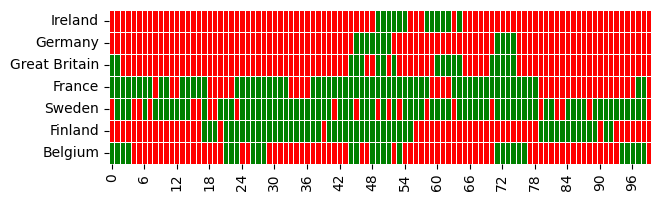

98
idx:  10
[0.48329399999999995 0.49340099999999987 0.480189 0.458043
 0.4362749999999999 0.414435 0.40179300000000007 0.39287099999999997
 0.38528399999999996 0.39356700000000006]
remaining budget:  2.6608479999999997


/Users/charlotterodriguez/Desktop/Code/GitHub/venv_greenFL_2/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


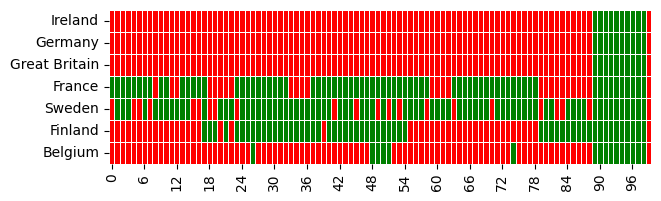

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Ireland,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Germany,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Great Britain,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
France,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,0
Sweden,0,1,1,1,0,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,0
Finland,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Belgium,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [82]:
win = Window(random_start=True)
av_mat = win.get_av_mat(fine_tuning=False)
win.apply_FT(av_mat)

**Definition of variables and useful functions:**

In [4]:

# key_words = []
# folders = []

# n_clients = len(countries)

# # Start and end dates:
# start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
# end_date = start_date + timedelta(hours=n_rounds-1)

# # data preparation:
# _dfs = load_data()

# datetime_values = get_datetime_values(_dfs, countries[0], start_date, end_date)

# # initialize the similarity matrix:
# # time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [i for i in range(n_rounds)]

# # functions:
# def save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix, folder):
#     dict_cols = dict(zip(formatted_array, datetime_values)) # get the datetime values
#     availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
#     availability_matrix_to_save.to_csv(folder+'/av-mat_'+key_word+'.csv', columns=datetime_values)

**Raw CI data:**

Let us display the raw data in between the chosen dates.

In [34]:
# fig = plt.figure(figsize=(8, 4))

# for country_idx, country in enumerate(countries):

#     df_country = _dfs[country]
#     df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

#     # plot:
#     plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])
#     plt.title('Carbon Intensity time evolution')
#     plt.legend()
#     _ = plt.xticks(rotation=90)  
#     plt.grid()
#     plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
#     plt.ylabel('CI (gCO2eq/kWh)')
    
# plt.savefig(os.path.join(main_folder,'raw_CI_data.png'), bbox_inches='tight')
# plt.show()

Lets compute the mean value for each country in between these two dates, and the global mean over all countries.

In [5]:
# mean_list=[]
# for country in countries:
#     CI_values=get_CI_values(_dfs, country, start_date, end_date)
#     mean_list.append(CI_values.mean())
# dict_countries_CI = dict(zip(countries, mean_list))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
# plt.plot(countries, mean_list, 'o')
# plt.title('Mean CI over the chosen period')
# plt.ylabel('CI (gCO2eq/kWh)')
# plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
# plt.grid()

# global_mean_CI = np.array(mean_list).mean()
# ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')

# median_CI = np.median(np.array(mean_list))
# ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')

# ax.legend()

# plt.savefig(main_folder+'/means.png', bbox_inches='tight')

# plt.show()

**Carbon Intensity matrix:**

This matrix contains CI values in gCO2eq/kWh.

In [7]:
# CI_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
# for country in countries:
#     CI_values=get_CI_values(_dfs, country, start_date, end_date)
#     CI_matrix.loc[country, :] = CI_values

**GHG matrix:** 

We suppose that the power draw for all clients is constant and equal. At the moment we take the constant **300 Watts**.

The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000

It contains the values of carbon fooprint of sustaining a certain power during ``round_duration`` hours

In [8]:
# power = 300/1000 # in kiloWatts
# round_duration = 1 # in hours: this is duration of a FL training round
# GHG_matrix = CI_matrix * power * round_duration / 1000
# GHG_mat_np = GHG_matrix.to_numpy()

## Creation of availability matrix with the third problem

### Take w=1

In [9]:


# rounds_axis = np.array([i for i in range(1, n_rounds+1)])

# w_dict = {
#     'no-w': np.ones(len(rounds_axis)),
#     'linear': 1/T_max*rounds_axis,
#     'ln': 1/np.log(T_max)*np.log(rounds_axis),
#     'exp': 1/np.exp(T_max/25)*np.exp(rounds_axis/25) - 1/np.exp(T_max/25),
#     # 'exp': 1/np.exp(T_max/10)*np.exp(rounds_axis/10) - 1/np.exp(T_max/10),
#     'inverse': np.flip(1/rounds_axis)
# }

### Solve first optimization problem with fairness parameter alpha=0.1

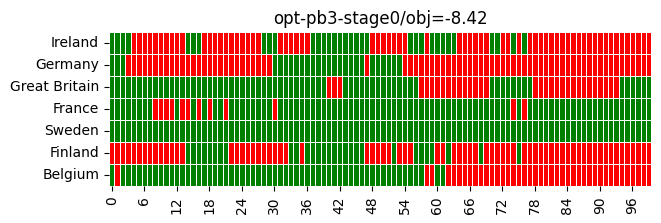

In [11]:
# T_max = n_rounds # in hours

# choice_w='no-w'
# w = np.ones(len(rounds_axis))
# alpha_f=0.1

# folder = main_folder+'/test'

# key_word = 'opt-pb3-stage0'

# GHG_mat = GHG_matrix.to_numpy()
# one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)

# x = cp.Variable(GHG_mat.shape, integer=True)
# objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1), alpha_f)))
# constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]
# prob = cp.Problem(objective, constraints)

# result = prob.solve(solver=cp.MOSEK, verbose=False)
# availability_matrix = np.array(x.value, dtype=np.int8)

# # plot:
# plot_availability_heatmap("", pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)
# save_availability_matrix(datetime_values, formatted_array, key_word, pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), folder=folder)

### Find the end of the training

In [10]:
# def find_largest_false_index(availability_matrix):
#     lst = availability_matrix.sum(axis=0) == 0
#     largest_index = -1
#     for i in range(len(lst)):
#         if lst[i] == False:
#             largest_index = i
#     return largest_index

# idx_end_train = find_largest_false_index(availability_matrix)

### Set the last 10 percent to available

idx:  10
[0.38524800000000003 0.3838979999999999 0.373302 0.36177599999999993
 0.344721 0.32854799999999995 0.319866 0.303882 0.28576799999999997
 0.28871399999999997]
remaining budget:  3.6242770000000006


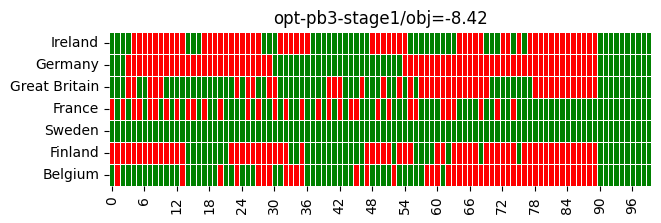

Countries lambda_2:  [0.67, 0.91, 0.5, -0.14, 1.0, 0.64, 0.55]
Mean lambda_2:  0.59


In [11]:
# carbon_budget = 7

# key_word = 'opt-pb3-stage1'

# percentage_fine_tuning = 0.1
# idx = int(percentage_fine_tuning*availability_matrix.shape[1])
# print('idx: ', idx)

# GHG_values = GHG_matrix.to_numpy()
# GHG_countries = sum(GHG_values[:,-idx:])
# print(GHG_countries)

# remaining_budget = carbon_budget - sum(GHG_countries)
# print('remaining budget: ', remaining_budget)

# availability_matrix[:, -idx:] = 1

# plot_availability_heatmap("", pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)
# save_availability_matrix(datetime_values, formatted_array, key_word, pd.DataFrame(availability_matrix, index = countries, columns = formatted_array), folder=folder)

# lam2_list, corr = av_mat_corr(pd.DataFrame(availability_matrix, index = countries, columns = formatted_array))
# print('Countries lambda_2: ',list(np.round(lam2_list, 2)))
# print('Mean lambda_2: ',np.round(corr, 2))

### Remove green slots with the highest carbon footprint so as not to exceed the carbon budget

We first put a mask on slots that we should not change in this step.

In [12]:
# mask = availability_matrix == 0
# mask[:, -idx:] = True

# sum(sum(mask))

368

Due to the previous step, the schedule is emitting extra-carbon.

In [13]:
# carbon_to_remove = sum(sum(GHG_matrix.to_numpy()*availability_matrix))-carbon_budget
# carbon_to_remove

2.552662999999999

/user/chrodrig/home/Documents/venv_fedstale/lib64/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


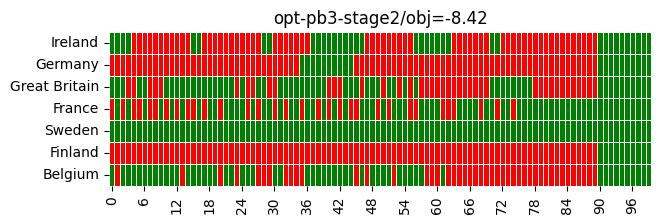

Carbon footprint of this schedule:  6.983786999999999


In [14]:
# key_word = 'opt-pb3-stage2'

# GHG_mat_np = GHG_matrix.to_numpy()

# # mask elements that unavailable, and mask last 10%
# # masked elements are set with the value 999999
# GHG_mat_masked = np.ma.array(data=GHG_mat_np, mask=mask, fill_value=999999)

# # flatten the masked array, but keep the mask
# flattened = GHG_mat_masked.flatten()
# availability_flattened = availability_matrix.flatten()

# # idx_map = np.array([i for i in range(len(flattened))]).reshape(GHG_mat_np.shape)
# # print(idx_map)

# # sort in increasing order the opposite of the flattened array, masked values are at the beginning
# # the original flattened array is sorted in decreasing order, masked values at the end
# idx_sort_flattened = (-flattened).argsort()

# # apply the sorting to the flattened array
# sorted_flattened = np.ma.array([flattened[idx] for idx in idx_sort_flattened])

# # compute the cumulative sum
# sorted_flattened_cumsum = sorted_flattened.cumsum()

# # we are then able to see up to which index we should remove availability
# threshold_idx = np.where(sorted_flattened_cumsum > carbon_to_remove)[0][0]

# # these are the indexes of slots that will be made non-available
# selected_idx = idx_sort_flattened[:threshold_idx+1]

# # modification of the availability matrix
# availability_flattened[selected_idx] = 0
# final_availability_matrix = availability_flattened.reshape(GHG_mat_np.shape)

# plot_availability_heatmap("", pd.DataFrame(final_availability_matrix, index = countries, columns = formatted_array), key_word, folder=folder, objective=result)
# print('Carbon footprint of this schedule: ',sum(sum(GHG_matrix.to_numpy()*final_availability_matrix)))


# save_availability_matrix(datetime_values, formatted_array, key_word, pd.DataFrame(final_availability_matrix, index = countries, columns = formatted_array), folder=folder)